In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import defaultdict
import pickle


Starting training...
Training for 2000 episodes
Episode 0: Avg Reward: -200.00, Avg Length: 200.0, Success Rate: 0.0%, Epsilon: 0.367
Episode 500: Avg Reward: -200.00, Avg Length: 200.0, Success Rate: 0.0%, Epsilon: 0.010


c:\Users\Asus\anaconda3\envs\py312\Lib\site-packages\gymnasium\envs\classic_control\mountain_car.py:179: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


Episode 1000: Avg Reward: -194.30, Avg Length: 194.3, Success Rate: 6.5%, Epsilon: 0.010
Episode 1500: Avg Reward: -171.78, Avg Length: 171.8, Success Rate: 13.4%, Epsilon: 0.010

Training completed!
Final success rate: 21.4%


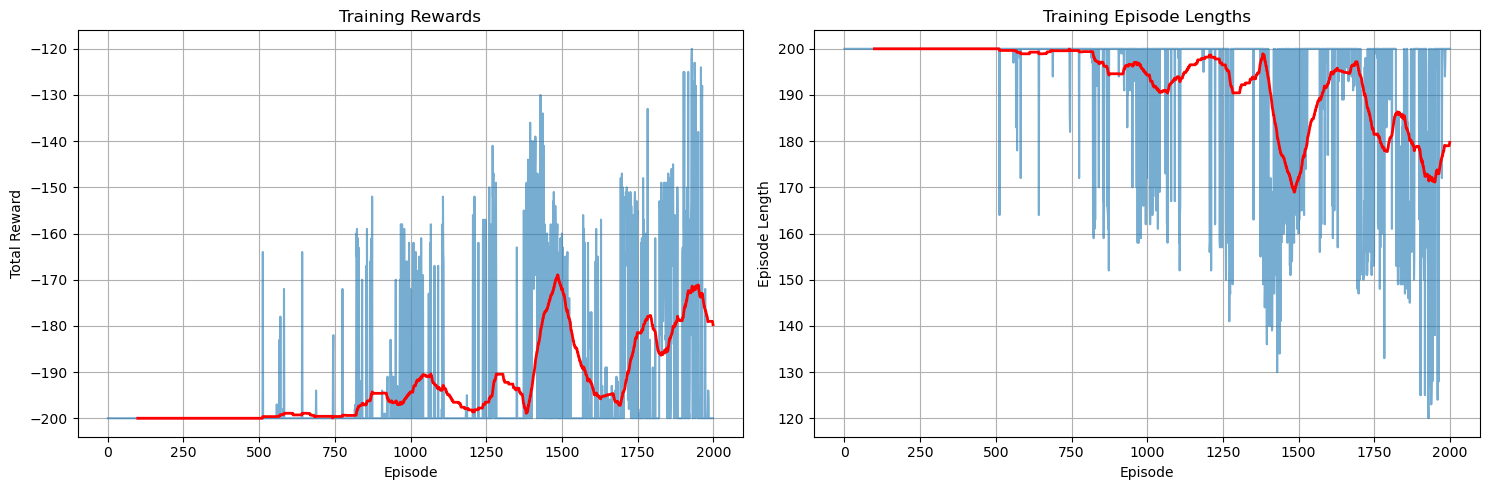

Model saved as 'mountain_car_q_agent.pkl'

Testing agent for 5 episodes...
Episode 1: Failed in 200 steps. Reward: -200.0
Episode 2: Failed in 200 steps. Reward: -200.0
Episode 3: Failed in 200 steps. Reward: -200.0
Episode 4: Failed in 200 steps. Reward: -200.0
Episode 5: SUCCESS in 163 steps! Reward: -163.0

Test Results:
Success Rate: 20.0%
Average Steps: 192.6
Average Reward: -192.60

To test with visual rendering, run:

Testing agent for 3 episodes...
Episode 1: Failed in 200 steps. Reward: -200.0
Episode 2: Failed in 200 steps. Reward: -200.0
Episode 3: Failed in 200 steps. Reward: -200.0

Test Results:
Success Rate: 0.0%
Average Steps: 200.0
Average Reward: -200.00
([-200.0, -200.0, -200.0], [200, 200, 200])


In [8]:

class QLearningAgent:
    def __init__(self, n_actions, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Q-Learning agent for Mountain Car environment
        
        Args:
            n_actions: Number of possible actions
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for epsilon
            epsilon_min: Minimum epsilon value
        """
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-table as defaultdict for sparse representation
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        
    def discretize_state(self, state, n_bins=20):
        """
        Discretize continuous state space into bins
        Mountain Car has 2 continuous state variables: position and velocity
        """
        position, velocity = state
        
        # Define bounds for discretization
        pos_bins = np.linspace(-1.2, 0.6, n_bins)
        vel_bins = np.linspace(-0.07, 0.07, n_bins)
        
        # Find which bin each state variable belongs to
        pos_idx = np.digitize(position, pos_bins)
        vel_idx = np.digitize(velocity, vel_bins)
        
        # Clip to valid range
        pos_idx = np.clip(pos_idx, 0, n_bins - 1)
        vel_idx = np.clip(vel_idx, 0, n_bins - 1)
        
        return (pos_idx, vel_idx)
    
    def choose_action(self, state):
        """
        Choose action using epsilon-greedy policy
        """
        discrete_state = self.discretize_state(state)
        
        if np.random.random() < self.epsilon:
            # Explore: choose random action
            return np.random.choice(self.n_actions)
        else:
            # Exploit: choose best known action
            q_values = self.q_table[discrete_state]
            return np.argmax(q_values)
    
    def update_q_table(self, state, action, reward, next_state, done):
        """
        Update Q-table using Q-learning update rule
        Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]
        """
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        # Current Q-value
        current_q = self.q_table[discrete_state][action]
        
        # Calculate target Q-value
        if done:
            target_q = reward
        else:
            next_q_values = self.q_table[discrete_next_state]
            target_q = reward + self.gamma * np.max(next_q_values)
        
        # Update Q-value
        self.q_table[discrete_state][action] += self.lr * (target_q - current_q)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save_model(self, filename):
        """Save the Q-table to a file"""
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
    
    def load_model(self, filename):
        """Load the Q-table from a file"""
        with open(filename, 'rb') as f:
            q_dict = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(self.n_actions), q_dict)

def train_agent(n_episodes=5000, render_every=1000):
    """
    Train the Q-learning agent on Mountain Car environment
    """
    # Create environment
    env = gym.make('MountainCar-v0')
    
    # Create agent
    agent = QLearningAgent(
        n_actions=env.action_space.n,
        learning_rate=0.1,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    # Training metrics
    episode_rewards = []
    episode_lengths = []
    success_count = 0
    
    print("Starting training...")
    print(f"Training for {n_episodes} episodes")
    
    for episode in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Handle gym's new API
            
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            # Choose and take action
            action = agent.choose_action(state)
            result = env.step(action)
            
            # Handle different gym API versions
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            
            # Update agent
            agent.update_q_table(state, action, reward, next_state, done)
            
            # Update metrics
            state = next_state
            total_reward += reward
            steps += 1
            
            # Render occasionally during training
            if episode % render_every == 0 and episode > 0:
                env.render()
        
        # Track success (reaching the goal)
        if state[0] >= 0.5:  # Goal position
            success_count += 1
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        # Print progress
        if episode % 500 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if episode_rewards else 0
            avg_length = np.mean(episode_lengths[-100:]) if episode_lengths else 0
            success_rate = success_count / (episode + 1) * 100
            print(f"Episode {episode}: Avg Reward: {avg_reward:.2f}, "
                  f"Avg Length: {avg_length:.1f}, Success Rate: {success_rate:.1f}%, "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    env.close()
    
    print(f"\nTraining completed!")
    print(f"Final success rate: {success_count/n_episodes*100:.1f}%")
    
    return agent, episode_rewards, episode_lengths

def test_agent(agent, n_episodes=10, render=True):
    """
    Test the trained agent
    """
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)
    
    # Set epsilon to 0 for pure exploitation
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    test_rewards = []
    test_lengths = []
    successes = 0
    
    print(f"\nTesting agent for {n_episodes} episodes...")
    
    for episode in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
            
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            result = env.step(action)
            
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if render:
                env.render()
        
        if state[0] >= 0.5:
            successes += 1
            print(f"Episode {episode + 1}: SUCCESS in {steps} steps! Reward: {total_reward}")
        else:
            print(f"Episode {episode + 1}: Failed in {steps} steps. Reward: {total_reward}")
        
        test_rewards.append(total_reward)
        test_lengths.append(steps)
    
    env.close()
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    print(f"\nTest Results:")
    print(f"Success Rate: {successes/n_episodes*100:.1f}%")
    print(f"Average Steps: {np.mean(test_lengths):.1f}")
    print(f"Average Reward: {np.mean(test_rewards):.2f}")
    
    return test_rewards, test_lengths

def plot_training_progress(episode_rewards, episode_lengths):
    """
    Plot training progress
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot rewards
    ax1.plot(episode_rewards, alpha=0.6)
    # Plot moving average
    window = 100
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', linewidth=2)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Rewards')
    ax1.grid(True)
    
    # Plot episode lengths
    ax2.plot(episode_lengths, alpha=0.6)
    # Plot moving average
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_lengths)), moving_avg, 'r-', linewidth=2)
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Episode Length')
    ax2.set_title('Training Episode Lengths')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the agent
    agent, rewards, lengths = train_agent(n_episodes=2000)
    
    # Plot training progress
    plot_training_progress(rewards, lengths)
    
    # Save the trained model
    agent.save_model('mountain_car_q_agent.pkl')
    print("Model saved as 'mountain_car_q_agent.pkl'")
    
    # Test the agent
    test_rewards, test_lengths = test_agent(agent, n_episodes=5, render=False)
    
    print("\nTo test with visual rendering, run:")
    print(test_agent(agent, n_episodes=3, render=True))